# Cassandra datasource

### 1. Init and check PySpark configuration

In [1]:
!pip list | grep spark

findspark                   2.0.1
pyspark                     3.5.4


In [2]:
import uuid
from typing import Literal

import findspark
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, when, udf
from pyspark.sql.types import BooleanType, StringType, IntegerType

import measurment_tools as mt

In [3]:
findspark.init()

spark = SparkSession.builder.appName("test").getOrCreate()
df = spark.createDataFrame([(1, "Alice"), (2, "Bob")], ["id", "name"])
df.show()

25/05/22 23:37:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+



### 2. Create a Cassandra session & read data

In [4]:
spark = SparkSession.builder \
    .appName("CassandraTest") \
    .config("spark.cassandra.connection.host", "127.0.0.1") \
    .config("spark.cassandra.connection.port", "9042") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.0") \
    .config("spark.cassandra.output.concurrent.writes", 8) \
    .getOrCreate()

25/05/22 23:37:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
df = spark.read.csv("data/first_million_airline.csv", header=True, inferSchema=True)

In [6]:
df.show(2, truncate=False)

25/05/22 23:37:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|Month|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|53               |32     |-8      |1642   |1650      |1545      |65            |NA           

### 3. Data preprocessing

- generate primary key
- Replace 'NA' with NULL
- CamelCase -> snake_case due to insensitive nature of Cassandra

In [7]:
# replace all 'NA' values with None
df = df.replace('NA', None)

# convert column names to match Cassandra schema
df = df.select(
    col("Year").cast(IntegerType()).alias("year"),
    col("Month").cast(IntegerType()).alias("month"),
    col("DayofMonth").cast(IntegerType()).alias("day_of_month"),
    col("DayOfWeek").cast(IntegerType()).alias("day_of_week"),
    col("DepTime").cast(IntegerType()).alias("dep_time"),
    col("CRSDepTime").cast(IntegerType()).alias("crs_dep_time"),
    col("ArrTime").cast(IntegerType()).alias("arr_time"),
    col("CRSArrTime").cast(IntegerType()).alias("crs_arr_time"),
    col("UniqueCarrier").cast(StringType()).alias("unique_carrier"),
    col("FlightNum").cast(IntegerType()).alias("flight_num"),
    col("TailNum").cast(StringType()).alias("tail_num"),
    col("ActualElapsedTime").cast(IntegerType()).alias("actual_elapsed_time"),
    col("CRSElapsedTime").cast(IntegerType()).alias("crs_elapsed_time"),
    col("AirTime").cast(IntegerType()).alias("air_time"),
    col("ArrDelay").cast(IntegerType()).alias("arr_delay"),
    col("DepDelay").cast(IntegerType()).alias("dep_delay"),
    col("Origin").cast(StringType()).alias("origin"),
    col("Dest").cast(StringType()).alias("dest"),
    col("Distance").cast(IntegerType()).alias("distance"),
    col("TaxiIn").cast(IntegerType()).alias("taxi_in"),
    col("TaxiOut").cast(IntegerType()).alias("taxi_out"),
    col("Cancelled").cast(BooleanType()).alias("cancelled"),
    col("CancellationCode").cast(StringType()).alias("cancellation_code"),
    col("Diverted").cast(BooleanType()).alias("diverted"),
    col("CarrierDelay").cast(IntegerType()).alias("carrier_delay"),
    col("WeatherDelay").cast(IntegerType()).alias("weather_delay"),
    col("NASDelay").cast(IntegerType()).alias("nas_delay"),
    col("SecurityDelay").cast(IntegerType()).alias("security_delay"),
    col("LateAircraftDelay").cast(IntegerType()).alias("late_aircraft_delay")
)

In [8]:
df.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day_of_month', 'int'),
 ('day_of_week', 'int'),
 ('dep_time', 'int'),
 ('crs_dep_time', 'int'),
 ('arr_time', 'int'),
 ('crs_arr_time', 'int'),
 ('unique_carrier', 'string'),
 ('flight_num', 'int'),
 ('tail_num', 'string'),
 ('actual_elapsed_time', 'int'),
 ('crs_elapsed_time', 'int'),
 ('air_time', 'int'),
 ('arr_delay', 'int'),
 ('dep_delay', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('distance', 'int'),
 ('taxi_in', 'int'),
 ('taxi_out', 'int'),
 ('cancelled', 'boolean'),
 ('cancellation_code', 'string'),
 ('diverted', 'boolean'),
 ('carrier_delay', 'int'),
 ('weather_delay', 'int'),
 ('nas_delay', 'int'),
 ('security_delay', 'int'),
 ('late_aircraft_delay', 'int')]

### 5. Read data by RDD
- Create a table
- Load data into the table
- Query the data from the table

In [34]:
@mt.perf_timer
def read_from_cassandra():
    """Odczyt danych z Cassandra przy użyciu DataFrame"""
    rdd = spark.sparkContext.textFile("data/first_million_airline.csv")
    header = rdd.first()
    data = rdd.filter(lambda row: row != header).map(lambda line: line.split(","))
    print(data.count())
    return rdd
    
    

In [35]:
rdd = read_from_cassandra()

1000000
Function 'read_from_cassandra' took 1.50109 seconds to execute.


In [36]:
# @mt.perf_timer
# def write_to_cassandra_rdd():
#     """Zapis danych do Cassandra przy użyciu RDD"""
#     rdd = df.rdd.map(lambda row: (
#         row.year, row.month, row.day_of_month, row.day_of_week, row.dep_time,
#         row.crs_dep_time, row.arr_time, row.crs_arr_time, row.unique_carrier,
#         row.flight_num, row.tail_num, row.actual_elapsed_time, row.crs_elapsed_time,
#         row.air_time, row.arr_delay, row.dep_delay, row.origin, row.dest, row.distance,
#         row.taxi_in, row.taxi_out, row.cancelled, row.cancellation_code, row.diverted,
#         row.carrier_delay, row.weather_delay, row.nas_delay, row.security_delay, row.late_aircraft_delay
#     ))

#     # Save RDD to Cassandra
#     rdd.saveToCassandra(
#         keyspace="airline_data",
#         table="flights",
#         columns=[
#             "year", "month", "day_of_month", "day_of_week", "dep_time",
#             "crs_dep_time", "arr_time", "crs_arr_time", "unique_carrier",
#             "flight_num", "tail_num", "actual_elapsed_time", "crs_elapsed_time",
#             "air_time", "arr_delay", "dep_delay", "origin", "dest", "distance",
#             "taxi_in", "taxi_out", "cancelled", "cancellation_code", "diverted",
#             "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"
#         ]
#     )
    
# write_to_cassandra_rdd()

In [37]:
@mt.perf_timer
def load_data():
    """Load DataFrame to Cassandra"""
    df.write \
        .format("org.apache.spark.sql.cassandra") \
        .mode("append") \
        .options(table="flights", keyspace="airline_data") \
        .option("confirm.truncate", "true") \
        .save()

    print("Data successfully written to Cassandra!")

load_data()

Data successfully written to Cassandra!
Function 'load_data' took 36.86161 seconds to execute.


# 6. Questions

#### 6.1. When is the best time of day/day of week/time of year to fly to minimise delays?

In [11]:
# dataframe_copied with TimeOfDay
df_cp_tod = df.withColumn("time_of_day", when(col("dep_time") < 1200, "morning") \
                          .when(col("dep_time") < 1800, "afternoon") \
                          .otherwise("evening"))

@mt.perf_timer
def give_answer_61(df, by: Literal['time_of_day', 'day_of_week', 'month']):
    """Aggregate delay over datetimes"""
    df.groupBy(by) \
        .agg(avg("arr_delay").alias("avg_arr_delay")) \
        .orderBy("avg_arr_delay") \
    .show()

In [12]:
give_answer_61(df_cp_tod, by="time_of_day")

+-----------+------------------+
|time_of_day|     avg_arr_delay|
+-----------+------------------+
|    morning|2.4459977823343118|
|  afternoon| 7.234572221453625|
|    evening|14.833066122308884|
+-----------+------------------+

Function 'give_answer_61' took 2.16704 seconds to execute.


In [13]:
give_answer_61(df_cp_tod, by="day_of_week")

+-----------+-----------------+
|day_of_week|    avg_arr_delay|
+-----------+-----------------+
|          6|4.128138964063188|
|          2|5.877880735105949|
|          7|6.564614209544513|
|          1|6.790553160171357|
|          3|7.083955847920615|
|          4|8.947054619846986|
|          5|9.622120266886741|
+-----------+-----------------+

Function 'give_answer_61' took 1.45406 seconds to execute.


In [14]:
give_answer_61(df_cp_tod, by="month")

+-----+------------------+
|month|     avg_arr_delay|
+-----+------------------+
|    9| 3.431516993080203|
|   10| 4.768709703746022|
|   11| 5.335630161755363|
|    4|5.4188090749041695|
|    5| 5.445262952483169|
|    3| 7.244244935543278|
|    8| 7.784251111741886|
|    2| 7.865777777777778|
|    1|  8.46352294353986|
|    7| 8.554130767134003|
|    6| 9.731548185401659|
|   12|10.481813836778588|
+-----+------------------+

Function 'give_answer_61' took 0.99428 seconds to execute.


#### 6.2. Do older planes suffer more delays?

In [38]:
@mt.perf_timer
def give_answer_62(df):
    """Plot average arrival delay by year"""
    # calc avg arrival delay by year
    avg_delay_df = df.groupBy("year") \
        .agg(avg("arr_delay").alias("avg_arr_delay")) \
        .orderBy("year")
    
    # plot pandas df 
    pandas_df = avg_delay_df.toPandas()
    return pandas_df

Function 'give_answer_62' took 2.78905 seconds to execute.


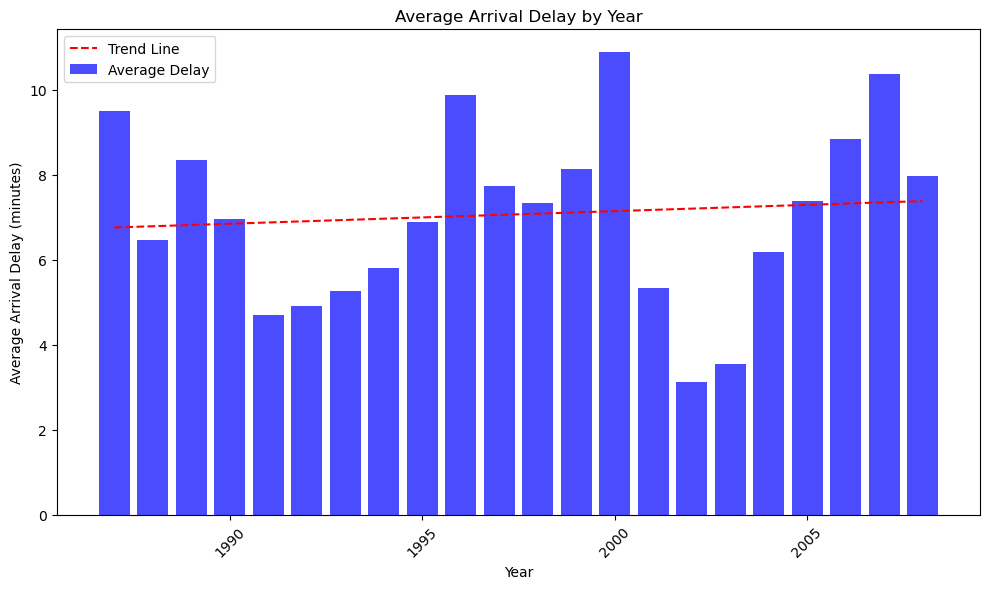

In [39]:
pandas_df = give_answer_62(df)
x = pandas_df["year"]
y = pandas_df["avg_arr_delay"]

plt.figure(figsize=(10, 6))
plt.bar(x, y, color="blue", alpha=0.7, label="Average Delay")

# add a trend line using numpy.polyfit
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color="red", linestyle="--", label="Trend Line")

plt.title("Average Arrival Delay by Year")
plt.xlabel("Year")
plt.ylabel("Average Arrival Delay (minutes)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### 6.3. How does the number of people flying between different locations change over time?

In [17]:
@mt.perf_timer
def give_answer_63(df):
    """Aggregate flight count over years and months"""
    # group by year, month, origin, and destination
    flight_trends = df.groupBy("year", "month", "origin", "dest") \
                    .agg(count("*").alias("flight_count"))

    # sort to observe trends
    flight_trends = flight_trends.orderBy("year", "month")
    flight_trends.show()

In [18]:
give_answer_63(df)

+----+-----+------+----+------------+
|year|month|origin|dest|flight_count|
+----+-----+------+----+------------+
|1987|   10|   CLE| BOS|           5|
|1987|   10|   ICT| PHX|           2|
|1987|   10|   SAN| MSP|           1|
|1987|   10|   LAX| SFO|          10|
|1987|   10|   PIA| STL|           1|
|1987|   10|   TPA| BDL|           1|
|1987|   10|   BOS| DCA|          13|
|1987|   10|   JAX| ATL|           3|
|1987|   10|   MEM| ATL|           3|
|1987|   10|   DFW| SNA|           2|
|1987|   10|   SFO| TUS|           1|
|1987|   10|   BTV| SYR|           1|
|1987|   10|   OKC| MCI|           3|
|1987|   10|   ATL| BNA|           2|
|1987|   10|   SJC| LAX|           8|
|1987|   10|   ATL| SFO|           3|
|1987|   10|   LAS| OAK|           4|
|1987|   10|   BTR| PNS|           2|
|1987|   10|   DEN| IAD|           2|
|1987|   10|   FLL| ORD|           4|
+----+-----+------+----+------------+
only showing top 20 rows

Function 'give_answer_63' took 2.32598 seconds to execute.


#### 6.4. How well does weather predict plane delays?

In [19]:
@mt.perf_timer
def give_answer_64(df):
    """Measure correlation between weather delay and arrival delay"""
    # replace NA as no delay
    df = df.fillna({"weather_delay": 0})

    # calc correlation
    correlation = df.stat.corr("weather_delay", "arr_delay")
    print(f"Correlation between weather_delay and arr_delay: {correlation}")

In [20]:
give_answer_64(df)

Correlation between weather_delay and arr_delay: 0.18311052728498503
Function 'give_answer_64' took 0.97382 seconds to execute.


#### 6.5. Can you detect cascading failures as delays in one airport create delays in others? Are there critical links in the system?

In [21]:
@mt.perf_timer
def give_answer_65(df):
    """Try to find a correlation between arrival and departure delays for flights exiting the same airport"""
    joined_df = df.alias("a").join(
        df.alias("b"),
        col("a.dest") == col("b.origin"),
        "inner"
    ).select(
        col("a.origin").alias("origin_airport"),
        col("a.dest").alias("connecting_airport"),
        col("b.dest").alias("final_airport"),
        col("a.arr_delay").alias("arrival_delay"),
        col("b.dep_delay").alias("departure_delay")
    )

    # correlation
    correlation = joined_df.stat.corr("arrival_delay", "departure_delay")
    print(f"Correlation between arrival and departure delays: {correlation:.4f}")

In [22]:
give_answer_65(df)

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 8) / 8]
Traceback (most recent call last):
  File "/home/tomek/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tomek/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 707, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 